# Lab (3): Advanced CNN architectures (20 pts)
The improved training pipeline for SimpleNN developed in Lab (2) still has limited performance. This is mainly because the SimpleNN has rather small capacity (learning capability) for CIFAR-10 task. Thus, in this lab we replace the SimpleNN model with a more advanced ResNet [3] architecture. We expect to see much higher accuracy on CIFAR-10 when using ResNets. Here, you may duplicate your jupyter notebook for Lab (2) as resnet-cifar10.ipynb to serve as a starting point.

In [3]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# useful libraries
import torchvision
import torchvision.transforms as transforms

from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

## Question (a)

Implement the ResNet-20 architecture by following Section 4.2 of the ResNet paper [3]. This lab is designed to have you learn how to implement a DNN model yourself, so do NOT borrow any code from online resource.


**Step 0: Set up ResNet-20 model**

In [4]:
class Residual_Block(nn.Module):
    def __init__(self, input, output, stride, downsample):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output)
        self.downsample = downsample

    def forward(self, x):
        x0 = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample is not None:
            x0 = self.downsample(x0)
        output += x0
        output = F.relu(output)
        return output

In [5]:
class ResNet20(nn.Module):
    def __init__(self, ):
        super(ResNet20, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.Residual_Layer(input=64, output=64, stride=1)   # only the first layer's has stride=1 -- no downsample
        self.layer2 = self.Residual_Layer(input=64, output=128, stride=2)
        self.layer3 = self.Residual_Layer(input=128, output=256, stride=2)
        self.layer4 = self.Residual_Layer(input=256, output=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 10)


    def Residual_Layer(self, input, output, stride):
        if stride == 2:
            downsample = nn.Sequential(
                nn.Conv2d(input, output, kernel_size=1, stride=2, padding=0),
                nn.BatchNorm2d(output)
            )
        else:
            downsample = None
        layer = nn.Sequential(
            Residual_Block(input, output, stride, downsample),
            Residual_Block(output, output, 1, None)
        )
        return layer

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = F.relu(output)
        # output = self.maxpool(output)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.avgpool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output



In [6]:
# initialize the model
model = ResNet20()

# specify the device for computation
#############################################
# check the device 
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)
    print("Model deployed on GPU.")
else:
    device = torch.device("cpu")
    model = model.to(device)
    print("Model deployed on CPU.")

#############################################

summary(model, input_size=(3,32,32))

Model deployed on GPU.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
    Residual_Block-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
   Residual_Block-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2

**Step 1: Set up preprocessing functions**

Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

In [7]:
#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose(
    [
    # transforms.Resize(224),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))]
)

transform_val = transforms.Compose(
    [
    # transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
    ]
)
#############################################

**Step 2: Set up dataset and dataloader**

In [8]:
# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset with data augmentation
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train   
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  
    shuffle=True,    
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  
    shuffle=False,     
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


**Step 3: Define traning and validation function**

In [9]:
def train_test_NN(train_loader, val_loader, model, epoch, lr, optimizer, criterion, device, checkpoint_folder, model_name):
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = lr

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(1, epoch+1):
        
        #######################
        # your code here
        # switch to train mode
        model.train()
        
        #######################
        
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want

        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            # add to totals
            train_loss += loss.item()
            total_examples += targets.size(0)
            correct_examples += correct.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        # print every 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")
            
        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()
        
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                
                # add to totals
                val_loss += loss.item()
                total_examples += targets.size(0)
                correct_examples += correct.item()
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        # print every 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(checkpoint_folder):
                os.makedirs(checkpoint_folder)
            # print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(checkpoint_folder, model_name))
            
        # print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

**Step 4: Define hyperparameters, optimizer and loss function**

In [8]:
# initialize model 
model = ResNet20().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"


**Step 5: Start training (Default)**

In [9]:

# start training model with data augmentation
l_train_acc_aug, _, l_val_acc_aug, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_first_try.pt"
)

==> Training starts!
EPOCH: 1, Training loss: 1.4733, Training accuracy: 0.4607
EPOCH: 1, Validation loss: 1.5070, Validation accuracy: 0.5068
EPOCH: 10, Training loss: 0.3451, Training accuracy: 0.8799
EPOCH: 10, Validation loss: 0.5452, Validation accuracy: 0.8248
EPOCH: 20, Training loss: 0.1834, Training accuracy: 0.9363
EPOCH: 20, Validation loss: 0.4360, Validation accuracy: 0.8730
EPOCH: 30, Training loss: 0.1073, Training accuracy: 0.9617
EPOCH: 30, Validation loss: 0.3772, Validation accuracy: 0.8952
==> Optimization finished! Best validation accuracy: 0.9016


**Step 6: Hyperparameter Tuning**

1. Tuning learning rate:

In [11]:
l_LR = [0.1, 0.05, 0.01, 0.005]
lr_val_acc = []

# hyperparameters
MOMENTUM = 0.9
REG = 1e-4
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for lr in l_LR:
    print(f"==> Current learning rate is: {lr}")

    # initialize model with swish activation function
    model = ResNet20().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=REG)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN( 
        train_loader, 
        val_loader, 
        model, 
        EPOCHS, 
        lr, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER,
        f"resnet20_lr_{lr}.pt"
    )

    # save the validation accuracy list
    lr_val_acc.append(l_val_acc)
    

==> Current learning rate is: 0.1
==> Training starts!
EPOCH: 1, Training loss: 1.8627, Training accuracy: 0.3231
EPOCH: 1, Validation loss: 1.5377, Validation accuracy: 0.4426
EPOCH: 10, Training loss: 0.4358, Training accuracy: 0.8501
EPOCH: 10, Validation loss: 0.5328, Validation accuracy: 0.8212
EPOCH: 20, Training loss: 0.2456, Training accuracy: 0.9152
EPOCH: 20, Validation loss: 0.3796, Validation accuracy: 0.8750
EPOCH: 30, Training loss: 0.1624, Training accuracy: 0.9427
EPOCH: 30, Validation loss: 0.3526, Validation accuracy: 0.8886
==> Optimization finished! Best validation accuracy: 0.8942
==> Current learning rate is: 0.05
==> Training starts!
EPOCH: 1, Training loss: 1.6675, Training accuracy: 0.3914
EPOCH: 1, Validation loss: 1.4659, Validation accuracy: 0.4746
EPOCH: 10, Training loss: 0.3891, Training accuracy: 0.8641
EPOCH: 10, Validation loss: 0.4600, Validation accuracy: 0.8476
EPOCH: 20, Training loss: 0.2045, Training accuracy: 0.9288
EPOCH: 20, Validation loss: 0

In [15]:
# print the best accuracy and its corresponding learning rate
print(f"Best accuracy: {np.max(lr_val_acc)} with learning rate: {l_LR[np.argmax(np.max(lr_val_acc, axis=1))]}")

Best accuracy: 0.9032 with learning rate: 0.05


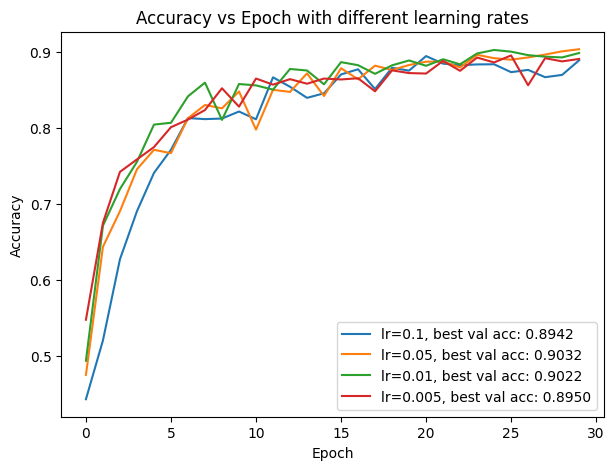

In [16]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, lr in enumerate(l_LR):
    plt.plot(np.arange(EPOCHS), lr_val_acc[i], label=f'lr={lr}, best val acc: {np.max(lr_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different learning rates')
plt.legend()
plt.show()

2. Tuning L2 regularization strength ($lr=0.05$):

In [18]:
l_REG = [1e-3, 1e-4, 1e-5, 0]
l2_reg_val_acc = []

# hyperparameters
MOMENTUM = 0.9
INITIAL_LR = 0.05
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for reg in l_REG:
    print(f"==> Current L2 regularization strength is: {reg}")
    # initialize model with swish activation function
    model = ResNet20().to(device)
    optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN(
        train_loader, 
        val_loader, 
        model, 
        EPOCHS, 
        INITIAL_LR, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER,
        f"resnet20_reg_{reg}.pt"
    )

    # save the best validation accuracy
    l2_reg_val_acc.append(l_val_acc)
    

==> Current L2 regularization strength is: 0.001
==> Training starts!
EPOCH: 1, Training loss: 1.7331, Training accuracy: 0.3709
EPOCH: 1, Validation loss: 1.5819, Validation accuracy: 0.4388
EPOCH: 10, Training loss: 0.4833, Training accuracy: 0.8358
EPOCH: 10, Validation loss: 0.5808, Validation accuracy: 0.7964
EPOCH: 20, Training loss: 0.3812, Training accuracy: 0.8717
EPOCH: 20, Validation loss: 0.6701, Validation accuracy: 0.7824
EPOCH: 30, Training loss: 0.3528, Training accuracy: 0.8794
EPOCH: 30, Validation loss: 0.6103, Validation accuracy: 0.8022
==> Optimization finished! Best validation accuracy: 0.8570
==> Current L2 regularization strength is: 0.0001
==> Training starts!
EPOCH: 1, Training loss: 1.7085, Training accuracy: 0.3778
EPOCH: 1, Validation loss: 1.4110, Validation accuracy: 0.4862
EPOCH: 10, Training loss: 0.3892, Training accuracy: 0.8656
EPOCH: 10, Validation loss: 0.4570, Validation accuracy: 0.8532
EPOCH: 20, Training loss: 0.2052, Training accuracy: 0.9280

In [19]:
print(f"Best accuracy: {np.max(l2_reg_val_acc)} with L2 regularization strength: {l_REG[np.argmax(np.max(l2_reg_val_acc, axis=1))]}")

Best accuracy: 0.9034 with L2 regularization strength: 1e-05


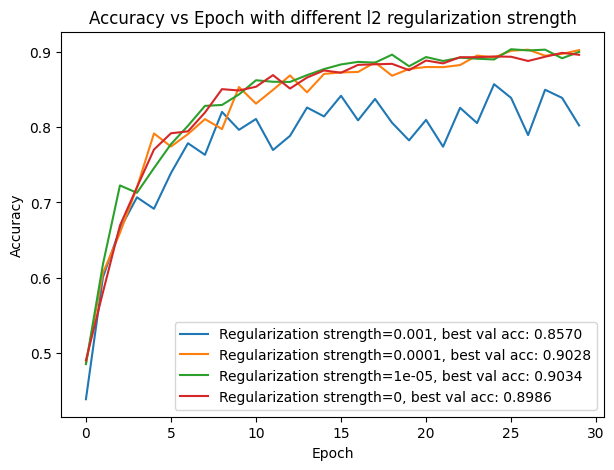

In [20]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, reg in enumerate(l_REG):
    plt.plot(np.arange(EPOCHS), l2_reg_val_acc[i], label=f'Regularization strength={reg}, best val acc: {np.max(l2_reg_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different l2 regularization strength')
plt.legend()
plt.show()

**3. Change to swish activation with $lr=0.005, L2\_reg = 1e-5$**

In [10]:
def swish(x):
    return x * torch.sigmoid(x)

In [11]:
class Residual_Block_swish(nn.Module):
    def __init__(self, input, output, stride, downsample):
        super(Residual_Block_swish, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output)
        self.downsample = downsample

    def forward(self, x):
        x0 = x
        output = self.conv1(x)
        output = self.bn1(output)
        output = swish(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample is not None:
            x0 = self.downsample(x0)
        output += x0
        output = swish(output)
        return output
    
class ResNet20_swish(nn.Module):
    def __init__(self, ):
        super(ResNet20_swish, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.Residual_Layer(input=64, output=64, stride=1)   # only the first layer's has stride=1 -- no downsample
        self.layer2 = self.Residual_Layer(input=64, output=128, stride=2)
        self.layer3 = self.Residual_Layer(input=128, output=256, stride=2)
        self.layer4 = self.Residual_Layer(input=256, output=512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, 10)


    def Residual_Layer(self, input, output, stride):
        if stride == 2:
            downsample = nn.Sequential(
                nn.Conv2d(input, output, kernel_size=1, stride=2, padding=0),
                nn.BatchNorm2d(output)
            )
        else:
            downsample = None
        layer = nn.Sequential(
            Residual_Block_swish(input, output, stride, downsample),
            Residual_Block_swish(output, output, 1, None)
        )
        return layer

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = swish(output)
        # output = self.maxpool(output)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.avgpool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output



In [10]:
# initialize model 
model_swish = ResNet20_swish().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.05
# momentum for optimizer
MOMENTUM = 0.9
# L2 regularization strength
REG = 1e-5

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 30
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc, _, l_val_acc, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model_swish, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_swish.pt"
)

==> Training starts!
EPOCH: 1, Training loss: 1.6601, Training accuracy: 0.3879
EPOCH: 1, Validation loss: 1.4542, Validation accuracy: 0.4784
EPOCH: 10, Training loss: 0.3607, Training accuracy: 0.8754
EPOCH: 10, Validation loss: 0.4773, Validation accuracy: 0.8452
EPOCH: 20, Training loss: 0.1726, Training accuracy: 0.9396
EPOCH: 20, Validation loss: 0.3407, Validation accuracy: 0.8980
EPOCH: 30, Training loss: 0.0878, Training accuracy: 0.9693
EPOCH: 30, Validation loss: 0.3444, Validation accuracy: 0.9066
==> Optimization finished! Best validation accuracy: 0.9120


**4. Increasing epochs**

In [16]:
# initialize model 
model_swish = ResNet20_swish().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.05
# momentum for optimizer
MOMENTUM = 0.9
# L2 regularization strength
REG = 1e-5

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 100
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc, _, l_val_acc, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model_swish, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_100epoch.pt"
)

==> Training starts!
EPOCH: 1, Training loss: 1.5608, Training accuracy: 0.4239
EPOCH: 1, Validation loss: 1.3165, Validation accuracy: 0.5396
EPOCH: 10, Training loss: 0.3587, Training accuracy: 0.8774
EPOCH: 10, Validation loss: 0.4232, Validation accuracy: 0.8568
EPOCH: 20, Training loss: 0.1702, Training accuracy: 0.9398
EPOCH: 20, Validation loss: 0.3475, Validation accuracy: 0.8924
EPOCH: 30, Training loss: 0.0883, Training accuracy: 0.9683
EPOCH: 30, Validation loss: 0.3973, Validation accuracy: 0.8998
EPOCH: 40, Training loss: 0.0507, Training accuracy: 0.9817
EPOCH: 40, Validation loss: 0.3661, Validation accuracy: 0.9176
EPOCH: 50, Training loss: 0.0307, Training accuracy: 0.9894
EPOCH: 50, Validation loss: 0.3649, Validation accuracy: 0.9198
EPOCH: 60, Training loss: 0.0276, Training accuracy: 0.9905
EPOCH: 60, Validation loss: 0.3874, Validation accuracy: 0.9214
EPOCH: 70, Training loss: 0.0152, Training accuracy: 0.9948
EPOCH: 70, Validation loss: 0.4400, Validation accura

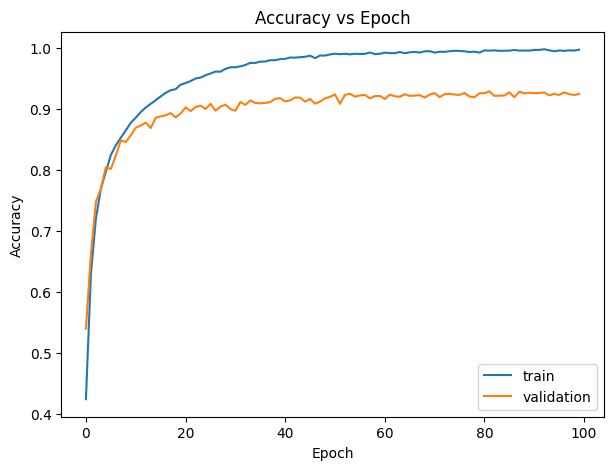

In [17]:
# plot the learning curve
plt.figure(figsize=(7, 5))
plt.plot(np.arange(EPOCHS), l_train_acc, label='train')
plt.plot(np.arange(EPOCHS), l_val_acc, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

**4. Add Weight Decay**

In [20]:
def train_test_WD(train_loader, val_loader, model, epoch, lr, decay_epoch, decay,\
                  optimizer, criterion, device, checkpoint_folder, model_name):
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = lr

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(1, epoch+1):
        
        #######################
        # your code here
        if i % decay_epoch == 0 and i != 0:
            current_learning_rate = current_learning_rate * decay
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f" %current_learning_rate)

        # switch to train mode
        model.train()
        #######################
        
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want

        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            # add to totals
            train_loss += loss.item()
            total_examples += targets.size(0)
            correct_examples += correct.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        # print every 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")
            
        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()
        
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                
                # add to totals
                val_loss += loss.item()
                total_examples += targets.size(0)
                correct_examples += correct.item()
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        # print every 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(checkpoint_folder):
                os.makedirs(checkpoint_folder)
            # print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(checkpoint_folder, model_name))
            
        # print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

In [21]:
# initialize model 
model_swish = ResNet20_swish().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.05
# momentum for optimizer
MOMENTUM = 0.9
# L2 regularization strength
REG = 1e-5
# Weight decay
DECAY = 0.8
DECAY_EPOCH = 10

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 100
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc, _, l_val_acc, _ = train_test_WD(
    train_loader, 
    val_loader, 
    model_swish, 
    EPOCHS, 
    INITIAL_LR, 
    DECAY_EPOCH,
    DECAY,
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet20_LR_Decay.pt"
)

==> Training starts!
Current learning rate has decayed to 0.050000
EPOCH: 1, Training loss: 1.6536, Training accuracy: 0.3856
EPOCH: 1, Validation loss: 1.5340, Validation accuracy: 0.4524
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.040000
EPOCH: 10, Training loss: 0.3359, Training accuracy: 0.8834
EPOCH: 10, Validation loss: 0.3879, Validation accuracy: 0.8704
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.0400

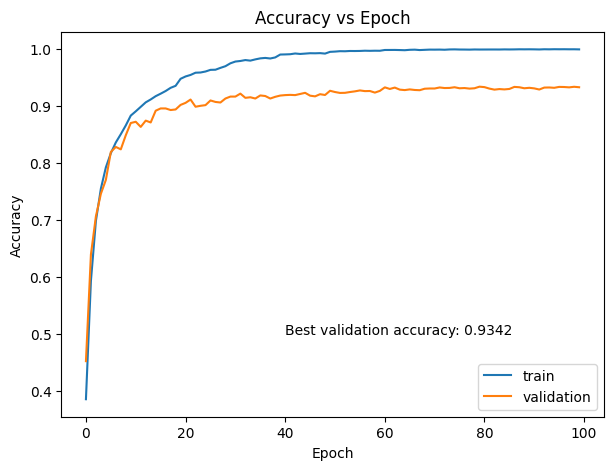

In [24]:
# plot the learning curve
plt.figure(figsize=(7, 5))
plt.plot(np.arange(EPOCHS), l_train_acc, label='train')
plt.plot(np.arange(EPOCHS), l_val_acc, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.text(40, 0.5, f"Best validation accuracy: {np.max(l_val_acc):.4f}")
plt.legend()
plt.show()

**Overfitting**

In [27]:
l_REG = np.logspace(-4, -5, 4)
l2_reg_val_acc = []

# hyperparameters
MOMENTUM = 0.9
INITIAL_LR = 0.05
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 100
CHECKPOINT_FOLDER = "./saved_model"
# Weight decay
DECAY = 0.8
DECAY_EPOCH = 10

for reg in l_REG:
    print(f"==> Current L2 regularization strength is: {reg}")
    # initialize model with swish activation function
    model = ResNet20_swish().to(device)
    optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_WD(
        train_loader, 
        val_loader, 
        model, 
        EPOCHS, 
        INITIAL_LR, 
        DECAY_EPOCH,
        DECAY,
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER,
        f"resnet20_reg_{reg}.pt"
    )

    # save the best validation accuracy
    l2_reg_val_acc.append(l_val_acc)
    

==> Current L2 regularization strength is: 0.0001
==> Training starts!
Current learning rate has decayed to 0.050000
EPOCH: 1, Training loss: 1.5702, Training accuracy: 0.4198
EPOCH: 1, Validation loss: 1.3854, Validation accuracy: 0.5168
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.040000
EPOCH: 10, Training loss: 0.3335, Training accuracy: 0.8842
EPOCH: 10, Validation loss: 0.3864, Validation accuracy: 0.8664
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.

In [28]:
print(f"Best accuracy: {np.max(l2_reg_val_acc)} with L2 regularization strength: {l_REG[np.argmax(np.max(l2_reg_val_acc, axis=1))]}")

Best accuracy: 0.9352 with L2 regularization strength: 0.0001


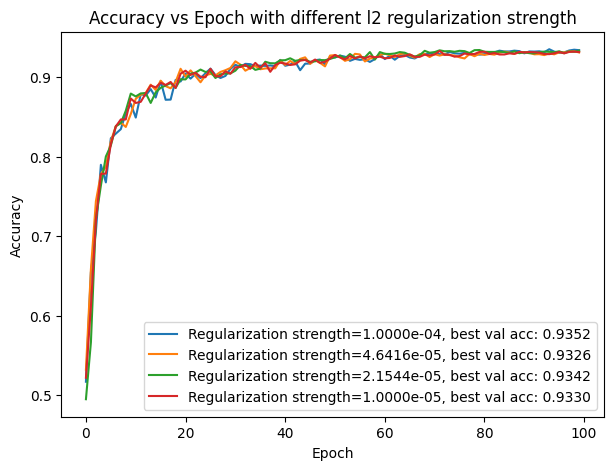

In [31]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, reg in enumerate(l_REG):
    plt.plot(np.arange(EPOCHS), l2_reg_val_acc[i], label=f'Regularization strength={reg:.4e}, best val acc: {np.max(l2_reg_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different l2 regularization strength')
plt.legend()
plt.show()

**Final Model**

swish activation, lr=0.05, L2_reg=0.0001, learning rate decay 80% every 10 epochs, 100 epochs.

In [32]:
# initialize model 
model_swish = ResNet20_swish().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.05
# momentum for optimizer
MOMENTUM = 0.9
# L2 regularization strength
REG = 1e-4
# Weight decay
DECAY = 0.8
DECAY_EPOCH = 10

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 100
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc, _, l_val_acc, _ = train_test_WD(
    train_loader, 
    val_loader, 
    model_swish, 
    EPOCHS, 
    INITIAL_LR, 
    DECAY_EPOCH,
    DECAY,
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER,
    "resnet_final.pt"
)

==> Training starts!
Current learning rate has decayed to 0.050000
EPOCH: 1, Training loss: 1.6158, Training accuracy: 0.4051
EPOCH: 1, Validation loss: 1.6625, Validation accuracy: 0.4388
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.050000
Current learning rate has decayed to 0.040000
EPOCH: 10, Training loss: 0.3460, Training accuracy: 0.8817
EPOCH: 10, Validation loss: 0.3843, Validation accuracy: 0.8682
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.040000
Current learning rate has decayed to 0.0400